## Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed 값 설정 및 전역 변수로 선언
seed = 42

## Load Data

In [3]:
import pandas as pd

df = pd.read_csv("./data/health_2023_cleaned_final.csv")

In [4]:
df.head()

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5cm단위),체중(5kg단위),허리둘레,시력(좌),시력(우),...,요단백,혈청크레아티닌,혈청지오티(AST),혈청지피티(ALT),감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석
0,2023,34735,46,2,9,155,70,92.0,1.2,1.2,...,1.0,0.5,26.0,24.0,50.0,1.0,1.0,0,NaN,NaN
1,2023,362482,36,2,13,150,65,96.0,1.0,0.8,...,1.0,1.1,22.0,29.0,24.0,1.0,1.0,0,NaN,NaN
2,2023,653166,11,1,13,160,70,85.0,1.0,1.2,...,1.0,0.9,22.0,21.0,27.0,3.0,1.0,1,0.0,0.0
3,2023,722514,49,1,10,165,80,89.0,1.2,1.2,...,1.0,0.7,53.0,69.0,53.0,2.0,1.0,0,NaN,NaN
4,2023,2555336,28,2,13,150,70,97.0,1.5,1.5,...,1.0,0.6,41.0,45.0,61.0,1.0,1.0,0,NaN,NaN


In [5]:
print(f"데이터 형태: {df.shape}")

데이터 형태: (332704, 30)


## Modeling

#### 1. 단순 데이터셋의 데이터들만 활용했을 때 예측 모델의 성능이 좋지 않아 콜레스테롤과 의학적으로 관련성이 높은 대사 지표들을 기반으로 파생 변수를 생성합니다

In [6]:
def create_cholesterol_features(df):
    """콜레스테롤 예측을 위한 파생변수 생성"""
    df_new = df.copy()
    
    # 파생변수와 계산 방법 저장용 딕셔너리
    feature_descriptions = {}
    
    # BMI 관련 파생변수
    bmi_cols = [col for col in df.columns if any(keyword in col for keyword in ['BMI', '체질량'])]
    if bmi_cols:
        bmi_col = bmi_cols[0]
        df_new['BMI_카테고리'] = pd.cut(df[bmi_col], bins=[0, 18.5, 23, 25, 30, 100], 
                                    labels=[0, 1, 2, 3, 4])  # 숫자로 인코딩
        df_new['비만여부'] = (df[bmi_col] >= 25).astype(int)
        df_new['BMI_제곱'] = df[bmi_col] ** 2
        feature_descriptions['BMI_카테고리'] = f"{bmi_col}를 [0, 18.5, 23, 25, 30, 100] 구간으로 범주화 (0: 저체중, 1: 정상, 2: 과체중, 3: 비만, 4: 고도비만)"
        feature_descriptions['비만여부'] = f"{bmi_col} >= 25인 경우 1, 아니면 0"
        feature_descriptions['BMI_제곱'] = f"{bmi_col}의 제곱"
    
    # 혈압 관련 파생변수
    sys_cols = [col for col in df.columns if any(keyword in col for keyword in ['수축기', '최고혈압'])]
    dia_cols = [col for col in df.columns if any(keyword in col for keyword in ['이완기', '최저혈압'])]
    if sys_cols and dia_cols:
        sys_col, dia_col = sys_cols[0], dia_cols[0]
        df_new['맥압'] = df[sys_col] - df[dia_col]
        df_new['평균동맥압'] = df[dia_col] + df_new['맥압'] / 3
        df_new['고혈압여부'] = ((df[sys_col] >= 140) | (df[dia_col] >= 90)).astype(int)
        feature_descriptions['맥압'] = f"{sys_col} - {dia_col}"
        feature_descriptions['평균동맥압'] = f"{dia_col} + (맥압 / 3)"
        feature_descriptions['고혈압여부'] = f"{sys_col} >= 140 또는 {dia_col} >= 90인 경우 1, 아니면 0"
    
    # 혈당 관련 파생변수
    glucose_cols = [col for col in df.columns if any(keyword in col for keyword in ['혈당', '글루코스'])]
    if glucose_cols:
        glucose_col = glucose_cols[0]
        df_new['당뇨여부'] = (df[glucose_col] >= 126).astype(int)
        df_new['혈당_제곱'] = df[glucose_col] ** 2
        df_new['혈당_정규화'] = np.log1p(df[glucose_col])
        feature_descriptions['당뇨여부'] = f"{glucose_col} >= 126인 경우 1, 아니면 0"
        feature_descriptions['혈당_제곱'] = f"{glucose_col}의 제곱"
        feature_descriptions['혈당_정규화'] = f"log(1 + {glucose_col})"
    
    # 간 기능 관련 파생변수
    alt_cols = [col for col in df.columns if any(keyword in col for keyword in ['ALT', 'SGPT'])]
    ast_cols = [col for col in df.columns if any(keyword in col for keyword in ['AST', 'SGOT'])]
    if alt_cols and ast_cols:
        alt_col, ast_col = alt_cols[0], ast_cols[0]
        df_new['AST_ALT_비율'] = df[ast_col] / (df[alt_col] + 0.001)
        df_new['간기능_이상'] = ((df[alt_col] > 40) | (df[ast_col] > 40)).astype(int)
        feature_descriptions['AST_ALT_비율'] = f"{ast_col} / ({alt_col} + 0.001)"
        feature_descriptions['간기능_이상'] = f"{alt_col} > 40 또는 {ast_col} > 40인 경우 1, 아니면 0"
    
    # 신장 기능 관련 파생변수
    creat_cols = [col for col in df.columns if '크레아티닌' in col]
    if creat_cols:
        creat_col = creat_cols[0]
        df_new['크레아티닌_이상'] = (df[creat_col] > 1.2).astype(int)
        feature_descriptions['크레아티닌_이상'] = f"{creat_col} > 1.2인 경우 1, 아니면 0"
    
    # 복합 위험도 점수
    risk_features = ['비만여부', '고혈압여부', '당뇨여부', '간기능_이상', '크레아티닌_이상']
    available_features = [f for f in risk_features if f in df_new.columns]
    df_new['대사증후군_점수'] = df_new[available_features].sum(axis=1)
    feature_descriptions['대사증후군_점수'] = f"{' + '.join(available_features)}의 합"
    
    # 상호작용 변수
    interaction_pairs = [
        ('비만여부', '고혈압여부', '비만_고혈압'),
        ('당뇨여부', '고혈압여부', '당뇨_고혈압'),
        ('고령여부', '대사증후군_점수', '고령_대사위험')
    ]
    for col1, col2, new_col in interaction_pairs:
        if col1 in df_new.columns and col2 in df_new.columns:
            df_new[new_col] = df_new[col1] * df_new[col2]
            feature_descriptions[new_col] = f"{col1} * {col2}"
    
    # 생성된 파생변수 확인 및 출력
    new_features = list(set(df_new.columns) - set(df.columns))
    new_features.sort()  # 정렬하여 출력
    
    print(f"생성된 파생변수: {len(new_features)}개")
    print("파생변수 목록:")
    for i, feature in enumerate(new_features, 1):
        print(f"  {i:2d}. {feature}: {feature_descriptions.get(feature, '설명 없음')}")

    return df_new

# 파생변수 생성 실행
df_enhanced = create_cholesterol_features(df)

생성된 파생변수: 11개
파생변수 목록:
   1. AST_ALT_비율: 혈청지오티(AST) / (혈청지피티(ALT) + 0.001)
   2. 간기능_이상: 혈청지피티(ALT) > 40 또는 혈청지오티(AST) > 40인 경우 1, 아니면 0
   3. 고혈압여부: 수축기혈압 >= 140 또는 이완기혈압 >= 90인 경우 1, 아니면 0
   4. 당뇨_고혈압: 당뇨여부 * 고혈압여부
   5. 당뇨여부: 식전혈당(공복혈당) >= 126인 경우 1, 아니면 0
   6. 대사증후군_점수: 고혈압여부 + 당뇨여부 + 간기능_이상 + 크레아티닌_이상의 합
   7. 맥압: 수축기혈압 - 이완기혈압
   8. 크레아티닌_이상: 혈청크레아티닌 > 1.2인 경우 1, 아니면 0
   9. 평균동맥압: 이완기혈압 + (맥압 / 3)
  10. 혈당_정규화: log(1 + 식전혈당(공복혈당))
  11. 혈당_제곱: 식전혈당(공복혈당)의 제곱


In [7]:
df_enhanced.head()

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5cm단위),체중(5kg단위),허리둘레,시력(좌),시력(우),...,평균동맥압,고혈압여부,당뇨여부,혈당_제곱,혈당_정규화,AST_ALT_비율,간기능_이상,크레아티닌_이상,대사증후군_점수,당뇨_고혈압
0,2023,34735,46,2,9,155,70,92.0,1.2,1.2,...,105.666667,0,0,9604.0,4.595120,1.083288,0,0,0,0
1,2023,362482,36,2,13,150,65,96.0,1.0,0.8,...,82.333333,0,0,12996.0,4.744932,0.758595,0,0,0,0
2,2023,653166,11,1,13,160,70,85.0,1.0,1.2,...,81.333333,0,0,9604.0,4.595120,1.047569,0,0,0,0
3,2023,722514,49,1,10,165,80,89.0,1.2,1.2,...,105.333333,1,0,5476.0,4.317488,0.768105,1,0,2,0
4,2023,2555336,28,2,13,150,70,97.0,1.5,1.5,...,97.666667,0,0,12544.0,4.727388,0.911091,1,0,1,0


##### 2. 콜레스테롤과 직접적인 연관을 갖고 있는 컬럼과 의미 없는 컬럼을 제외합니다

In [8]:
# 제외할 직접 콜레스테롤 특성
exclude_features = ['총콜레스테롤', 'LDL콜레스테롤', 'HDL콜레스테롤', '트리글리세라이드', '가입자일련번호']
actual_exclude = [col for col in exclude_features if col in df_enhanced.columns]

# 타겟 및 특성 분리
y = (df_enhanced['총콜레스테롤'] >= 200).astype(int)
X = df_enhanced.drop(columns=actual_exclude)

# 범주형 변수 처리
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 결측값 처리
X = X.dropna()
y = y[X.index]  # X에 맞춰 y도 필터링

print(f"최종 특성 수: {X.shape[1]}, 샘플 수: {X.shape[0]}")
print(f"양성 비율: {y.mean():.1%}")

최종 특성 수: 36, 샘플 수: 105497
양성 비율: 46.2%


##### 3. 데이터를 분할하고 표준화합니다

In [9]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4. 모델을 훈련합니다

In [10]:
# 모델 훈련
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=10,
    max_features='log2',
    random_state=seed,
    class_weight='balanced_subsample',
)

clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       min_samples_leaf=10, min_samples_split=5,
                       n_estimators=200, random_state=42)

#### 5. 예측 및 평가를 수행합니다

In [11]:
# 예측 및 평가
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

# 성능 지표 계산
def evaluate_model(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob),
        'sensitivity': cm[1,1] / (cm[1,1] + cm[1,0]),  # 민감도58
        'specificity': cm[0,0] / (cm[0,0] + cm[0,1]),  # 특이도
        'ppv': cm[1,1] / (cm[1,1] + cm[0,1]),          # 양성예측도
        'npv': cm[0,0] / (cm[0,0] + cm[1,0])           # 음성예측도
    }
    return metrics

metrics = evaluate_model(y_test, y_pred, y_prob)
print(f"모델 성능: AUC={metrics['auc']:.3f}, 정확도={metrics['accuracy']:.3f}")
print(f"민감도={metrics['sensitivity']:.3f}, 특이도={metrics['specificity']:.3f}")
print(f"양성예측도={metrics['ppv']:.3f}, 음성예측도={metrics['npv']:.3f}")

모델 성능: AUC=0.669, 정확도=0.621
민감도=0.637, 특이도=0.608
양성예측도=0.582, 음성예측도=0.661


#### 6. 특성 중요도를 계산합니다

In [12]:
# 특성 중요도 계산
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

# 상위 20개 특성 출력
top_features = feature_importance.head(20)
print("\n상위 20개 중요 특성:")
print(top_features.to_string(index=False, float_format='%.4f'))

# 파생변수 중요도 분석
original_features = set(df.columns)
derived_features = [f for f in feature_importance['feature'] if f not in original_features]
derived_importance = feature_importance[feature_importance['feature'].isin(derived_features)]

if len(derived_importance) > 0:
    total_derived_importance = derived_importance['importance'].sum()
    print(f"\n파생변수 기여도: {total_derived_importance:.3f} ({total_derived_importance*100:.1f}%)")
    print(f"상위 파생변수 10개:")
    print(derived_importance.head(10).to_string(index=False, float_format='%.4f'))


상위 20개 중요 특성:
    feature  importance
연령대코드(5세단위)      0.1002
      감마지티피      0.0729
        혈색소      0.0705
 AST_ALT_비율      0.0627
       허리둘레      0.0577
      평균동맥압      0.0497
 혈청지피티(ALT)      0.0482
     혈당_정규화      0.0452
         맥압      0.0446
      이완기혈압      0.0444
      혈당_제곱      0.0442
 식전혈당(공복혈당)      0.0436
 혈청지오티(AST)      0.0435
      수축기혈압      0.0420
       시도코드      0.0326
    혈청크레아티닌      0.0273
      시력(좌)      0.0263
      시력(우)      0.0259
  체중(5kg단위)      0.0255
  신장(5cm단위)      0.0238

파생변수 기여도: 0.261 (26.1%)
상위 파생변수 10개:
   feature  importance
AST_ALT_비율      0.0627
     평균동맥압      0.0497
    혈당_정규화      0.0452
        맥압      0.0446
     혈당_제곱      0.0442
      당뇨여부      0.0049
  대사증후군_점수      0.0048
    간기능_이상      0.0026
     고혈압여부      0.0016
  크레아티닌_이상      0.0008


#### 7. 최적 특성 개수를 탐색합니다

In [13]:
def find_optimal_features(X_train, X_test, y_train, y_test, feature_importance, n_features_list):
    """최적 특성 개수 탐색"""
    results = []
    
    for n_features in n_features_list:
        if n_features > len(X_train.columns):
            continue
            
        # 상위 n개 특성 선택
        top_features = feature_importance.head(n_features)['feature'].tolist()
        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]
        
        # 표준화
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        
        # 모델 훈련
        clf = RandomForestClassifier(n_estimators=200, random_state=seed, 
                                   class_weight='balanced', n_jobs=-1)
        clf.fit(X_train_scaled, y_train)
        
        # 평가
        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]
        metrics = evaluate_model(y_test, y_pred, y_prob)
        
        results.append({
            'n_features': n_features,
            **metrics,
            'top_features': top_features
        })
    
    return pd.DataFrame(results)

# 최적 특성 개수 탐색
n_features_list = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
results_df = find_optimal_features(X_train, X_test, y_train, y_test, 
                                 feature_importance, n_features_list)

print("\n특성 개수별 성능:")
print(results_df[['n_features', 'accuracy', 'auc', 'sensitivity', 'specificity']].round(3))

# 최적 모델 선택
best_idx = results_df['auc'].idxmax()
best_result = results_df.loc[best_idx]

print(f"\n최적 모델: {best_result['n_features']}개 특성")
print(f"AUC: {best_result['auc']:.3f}, 정확도: {best_result['accuracy']:.3f}")


특성 개수별 성능:
   n_features  accuracy    auc  sensitivity  specificity
0           1     0.573  0.603        0.682        0.480
1           2     0.583  0.610        0.610        0.560
2           3     0.546  0.567        0.543        0.548
3           5     0.579  0.606        0.507        0.640
4           7     0.592  0.627        0.514        0.659
5          10     0.603  0.641        0.526        0.668
6          15     0.600  0.641        0.511        0.677
7          20     0.611  0.652        0.521        0.689
8          25     0.615  0.661        0.524        0.692
9          30     0.617  0.661        0.528        0.693

최적 모델: 25개 특성
AUC: 0.661, 정확도: 0.615


#### 8. 최적 특성들을 출력합니다

In [14]:
# 최적 특성들 출력
print(f"\n선택된 {best_result['n_features']}개 핵심 특성:")
selected_features = best_result['top_features']
selected_importance = feature_importance[feature_importance['feature'].isin(selected_features)]

print(selected_importance.to_string(index=False, float_format='%.4f'))

# 파생변수 기여도 분석
selected_derived = [f for f in selected_features if f not in original_features]
print(f"\n선택된 파생변수: {len(selected_derived)}개")
if selected_derived:
    derived_contrib = selected_importance[selected_importance['feature'].isin(selected_derived)]
    print(derived_contrib.to_string(index=False, float_format='%.4f'))

# 성능 해석
auc_score = best_result['auc']
performance_level = (
    "매우 우수" if auc_score > 0.85 else
    "우수" if auc_score > 0.8 else
    "양호" if auc_score > 0.75 else
    "보통"
)

print(f"\n모델 성능 평가: {performance_level} (AUC: {auc_score:.3f})")
print(f"콜레스테롤 예측을 위한 핵심 지표 {len(selected_features)}개 식별 완료")




선택된 25개 핵심 특성:
    feature  importance
연령대코드(5세단위)      0.1002
      감마지티피      0.0729
        혈색소      0.0705
 AST_ALT_비율      0.0627
       허리둘레      0.0577
      평균동맥압      0.0497
 혈청지피티(ALT)      0.0482
     혈당_정규화      0.0452
         맥압      0.0446
      이완기혈압      0.0444
      혈당_제곱      0.0442
 식전혈당(공복혈당)      0.0436
 혈청지오티(AST)      0.0435
      수축기혈압      0.0420
       시도코드      0.0326
    혈청크레아티닌      0.0273
      시력(좌)      0.0263
      시력(우)      0.0259
  체중(5kg단위)      0.0255
  신장(5cm단위)      0.0238
       성별코드      0.0145
       흡연상태      0.0111
         치석      0.0111
       음주여부      0.0075
       당뇨여부      0.0049

선택된 파생변수: 6개
   feature  importance
AST_ALT_비율      0.0627
     평균동맥압      0.0497
    혈당_정규화      0.0452
        맥압      0.0446
     혈당_제곱      0.0442
      당뇨여부      0.0049

모델 성능 평가: 보통 (AUC: 0.661)
콜레스테롤 예측을 위한 핵심 지표 25개 식별 완료


# Visualizing

#### 1. 각종 모델 성능을 나타내는 지표를 출력합니다. (ROC Curve, Confusion Matrix, Feature Importance, AUC/Accuracy vs. Feature Count)

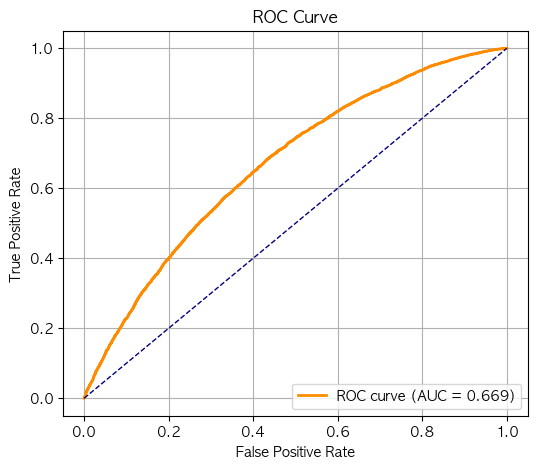

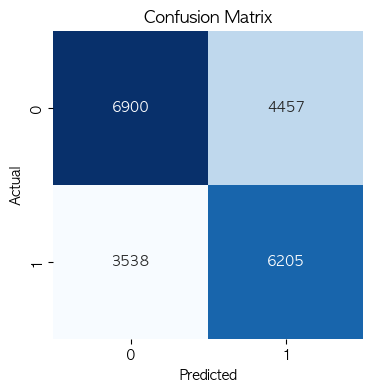

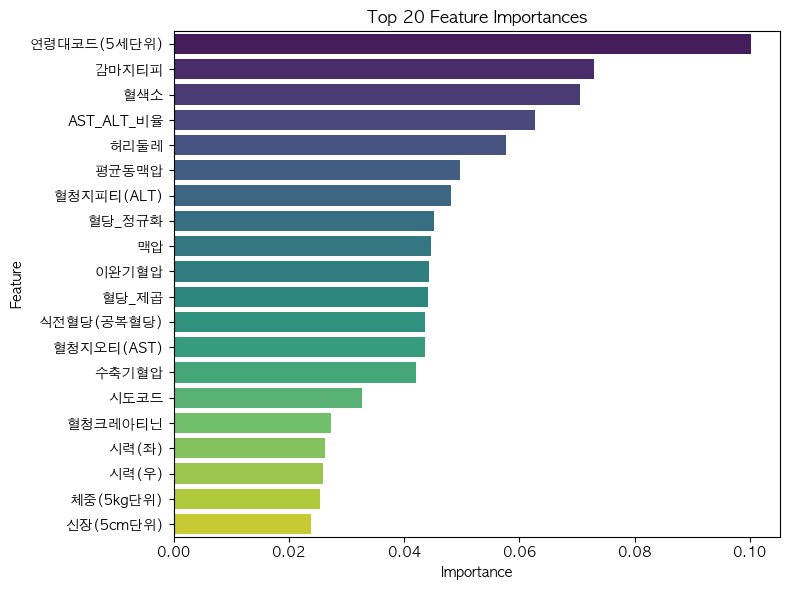

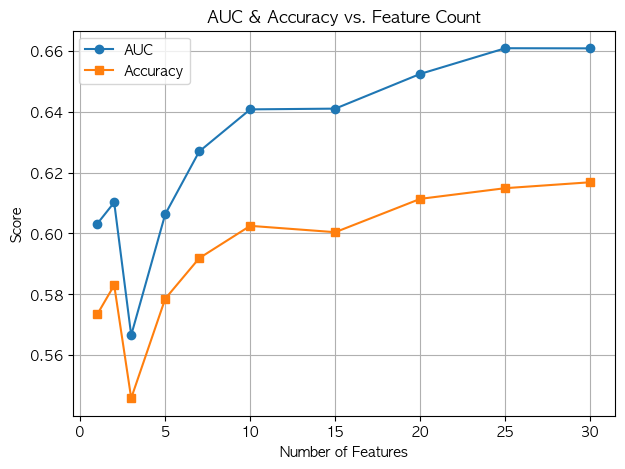

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.rc("font", family="AppleGothic")
plt.rc("axes", unicode_minus=False)

# 1. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('혼동 행렬 (Confusion Matrix)')
plt.show()

# 3. Feature Importance (Top 20)
plt.figure(figsize=(8, 6))
sns.barplot(
    y=top_features['feature'],
    x=top_features['importance'],
    palette='viridis'
)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 4. AUC/Accuracy vs. Feature Count
plt.figure(figsize=(7, 5))
plt.plot(results_df['n_features'], results_df['auc'], marker='o', label='AUC')
plt.plot(results_df['n_features'], results_df['accuracy'], marker='s', label='Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('AUC & Accuracy vs. Feature Count')
plt.legend()
plt.grid(True)
plt.show()

#### 2. 가장 중요한 특성인 나이와 콜레스테롤 관계를 시각화합니다.

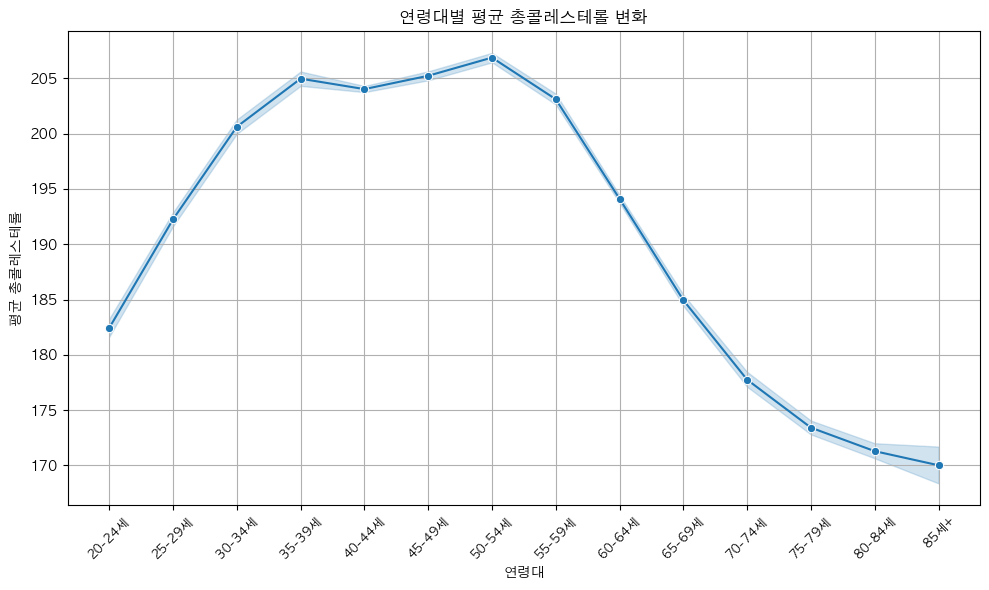

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_enhanced, x='연령대코드(5세단위)', y='총콜레스테롤', marker='o')
plt.title('연령대별 평균 총콜레스테롤 변화')
plt.xlabel('연령대')
plt.ylabel('평균 총콜레스테롤')

# x축 라벨을 실제 연령대로 변경
age_labels = {
    1: '0-4세',
    2: '5-9세',
    3: '10-14세',
    4: '15-19세',
    5: '20-24세',
    6: '25-29세',
    7: '30-34세', 
    8: '35-39세',
    9: '40-44세',
    10: '45-49세',
    11: '50-54세',
    12: '55-59세',
    13: '60-64세',
    14: '65-69세',
    15: '70-74세',
    16: '75-79세',
    17: '80-84세',
    18: '85세+'
}

# 현재 데이터에 있는 연령대코드만 추출해서 라벨 설정
current_codes = sorted(df_enhanced['연령대코드(5세단위)'].unique())
plt.xticks(current_codes, [age_labels[code] for code in current_codes], rotation=45, fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

# Insight - Model

1. 예측 모델의 성능이 좋지 않게 나와 고콜레스테롤 여부를 예측하는 이진 분류 모델(고콜레스테롤 vs 정상)로 만들어 보았습니다.
    - 모델은 RandomForestClassifier을 사용하고 평가 지표는 ROC, 혼동 행렬 등을 사용하여 나타내었습니다.
2.  모델의 성능을 평가한 결과는 다음과 같습니다.
    - AUC : 67%
    - 정확도 : 62% (양성예측도 57%, 음성예측도 68%)
    - 민감도 : 64% (실제 위험군을 위함군으로 예측한 비율)
    - 특이도 : 61% (실제 정상인을 정상인으로 판정한 비율)
    - F1-Score : 62% (모델이 위험군과 정상군을 구분하는 전반적 능력)
3. 장점
    - 위험군의 2/3 가량을 올바르게 탐지했습니다.
    - 전체적으로 균형 잡힌 성능을 보입니다.
4. 단점
    - 특이도가 61%로 정상인의 39%를 위험군으로 오판했습니다.
		- 민감도도 64%에 그쳐 실제 위험군의 36%를 놓쳤습니다.
		- 전반적으로 중간 수준의 성능을 보여 신뢰성이 제한적입니다.
5. 종합 결론으로는 연구/스크리닝 목적으로는 활용 가능하나, 임상 진단 도구로는 추가 개선이 필요한 수준입니다.
    - 콜레스테롤과 큰 관련이 있는 가족력, 식습관, 혈액 지표등을 추가하면 개선의 여지가 충분합니다.
   

# Insight - Result

1. 특성 개수에 따른 성능 변화 추이
    - 10개 특성에서 급격한 성능 향상을 보여, 10개의 특성만을 입력 지표로 사용한 부분을 분석해보았습니다.
2. 특성 중요도 Top 10
    - 연령대코드(5세단위), 감마지티피, 혈색소, AST_ALT_비율, 허리둘레, 혈청지피티(ALT), 평균동맥압, 혈당_정규화, 식전혈당(공복혈당)
3. 특성 인사이트는 다음과 같습니다(의학적으로 이미 드러난 가족력, 식이습관 등을 제외하고).
    - 나이가 콜레스테롤 강력한 요인으로 작용합니다.
	    - 20대 후반부터 30대에 이르기까지 각별한 주의가 필요합니다.
    - 간 기능의 핵심적 역할을 확인했습니다.
        - 감마지티피, AST_ALT_비율, 혈청지피티(ALT)가 각각 2, 4, 7위로, 간이 콜레스테롤 합성 및 대사의 중추 기관임을 확인하였습니다.
        - 간 효소 이상 = 지질 대사 장애의 강력한 신호
    - 혈액 관련 지표들도 중요하게 나타났습니다.
        - 혈색소, 평균동맥압, 맥압, 이완기혈압이 각각 3, 6, 9, 10위로 나타났습니다.
        - 콜레스테롤은 심혈관 질환과 밀접환 관계를 갖고 있음이 나타났습니다.

# Lesson

1. 콜레스테롤은 종합적 건강 대사의 거울입니다.
    - 단일 질환이 아닌 전신 대사 상태의 결과물입니다.
    - 간-혈관-당대사의 통합적인 관리가 필요합니다.
2. 20대 후반에서 30대가 콜레스테롤 관리의 골든타임입니다.
    - 20대부터 기하급수적으로 위험도가 증가합니다.
    - 예방적 개입의 최적 시점임을 제시합니다.
3. 대사증후군 중심의 통합 관리가 필요합니다.
    - 콜레스테롤만 단독 관리하는 것은 비효율적입니다.
    - 간 건강 + 복부비만 + 혈압 + 혈당을 패키지로 관리하여야 합니다.
